In [1]:
import pandas as pd
import time
from os.path import join
import json 
import numpy as np 
from tqdm import tqdm
import numpy as np
from os import listdir, path
import matplotlib.pyplot as plt


In [2]:
data_dir = '/workspaces/predictive_maintenance/data/raw'

listdir(data_dir)

# keep only the files that end with .parquet
files = [join(data_dir,f)  for f in listdir(data_dir) if f.endswith('.parquet')]



In [3]:
# creat a dict key is the file name and value is the path 
files_dict = {f.split('/')[-1].split('.')[0]:f for f in files}
files_dict

{'PdM_failures': '/workspaces/predictive_maintenance/data/raw/PdM_failures.parquet',
 'PdM_machines': '/workspaces/predictive_maintenance/data/raw/PdM_machines.parquet',
 'PdM_telemetry2': '/workspaces/predictive_maintenance/data/raw/PdM_telemetry2.parquet',
 'PdM_errors': '/workspaces/predictive_maintenance/data/raw/PdM_errors.parquet',
 'PdM_maint': '/workspaces/predictive_maintenance/data/raw/PdM_maint.parquet',
 'PdM_telemetry': '/workspaces/predictive_maintenance/data/raw/PdM_telemetry.parquet'}

In [4]:
# read all the files into dataframes, the name of the dataframe is df_ + the name of the file


df_PdM_errors = pd.read_parquet(files_dict['PdM_errors'])
df_PdM_maint = pd.read_parquet(files_dict['PdM_maint'])
df_PdM_telemetry = pd.read_parquet(files_dict['PdM_telemetry'])
df_PdM_failures = pd.read_parquet(files_dict['PdM_failures'])
df_PdM_machines = pd.read_parquet(files_dict['PdM_machines'])
    

In [5]:
display(df_PdM_errors.head())
display(df_PdM_maint.head())
display(df_PdM_telemetry.head())
display(df_PdM_failures.head())
display(df_PdM_machines.head())


,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [6]:
df_PdM_telemetry
# join the telemetry and failures dataframes
df_failures_telemetry = df_PdM_telemetry.merge(df_PdM_failures, on=['datetime', 'machineID'], how='left')

In [7]:
df_failures_telemetry.to_parquet('/workspaces/predictive_maintenance/data/interim/df_failures_telemetry.parquet')

In [8]:
df_failures_telemetry.failure.value_counts()

comp2    259
comp1    192
comp4    179
comp3    131
Name: failure, dtype: int64

In [9]:
def map_failure(x):
    if pd.isna(x):
        return 0
    else:
        x  = int(x.replace('comp',''))
    return x


df_failures_telemetry['failure'] = df_failures_telemetry.failure.apply(map_failure)
df_failures_telemetry['failure_binary'] = df_failures_telemetry.failure.apply(lambda x: 1 if x > 0 else 0)

In [10]:
# cantidad de fallas por MachineID
df_failures_telemetry.groupby('machineID').failure.sum().sort_values(ascending=False).to_frame()


,failure
machineID,
99,52
37,43
22,41
98,39
17,39
...,...
29,3
72,2
57,2


In [11]:
df_fallas_por_maquina =  df_failures_telemetry.groupby('machineID').failure_binary.sum().sort_values(ascending=False).to_frame()

In [12]:
df_fallas_por_maquina = df_fallas_por_maquina.merge(df_PdM_machines, on='machineID', how='left')

In [13]:
df_fallas_por_maquina.head()

,machineID,failure_binary,model,age
0,99,19,model1,14
1,98,16,model2,20
2,17,15,model1,14
3,22,15,model1,14
4,37,14,model1,16


In [52]:
df_fallas_por_maquina.groupby('model').failure_binary.sum().sort_values(ascending=False).to_frame()

,failure_binary
model,
model3,221
model1,189
model4,183
model2,168


In [14]:

# agrupar por modelo, sumar las fallas y contar la cantidad de maquinas por modelo
fallas_modelo = df_fallas_por_maquina.groupby('model').agg(
    suma_fallas = ('failure_binary', 'sum'),
    cantidad_maquinas = ('machineID', 'count'),
).sort_values(by='suma_fallas', ascending=False)


fallas_modelo['ratio'] = fallas_modelo.suma_fallas / fallas_modelo.cantidad_maquinas

fallas_modelo

,suma_fallas,cantidad_maquinas,ratio
model,,,
model3,221,35,6.314286
model1,189,16,11.812500
model4,183,32,5.718750
model2,168,17,9.882353


In [15]:

fallas_por_edad =  df_fallas_por_maquina.groupby('age').failure_binary.mean().sort_values(ascending=False).to_frame()
fallas_por_edad

,failure_binary
age,
14,10.357143
16,10.200000
18,10.000000
20,9.714286
19,9.500000
15,9.333333
17,8.428571
6,6.500000
2,6.333333


In [ ]:
fallas_por_edad =  df_fallas_por_maquina.groupby('age').failure_binary.mean().sort_values(ascending=False).to_frame()
fallas_por_edad

In [16]:
df_fallas_por_maquina.groupby( ['model','age']).failure_binary.mean().sort_values(ascending=False).to_frame().head()

failure_binary
model  age                
model1 14        16.333333
model4 18        14.000000
model2 20        14.000000
       16        13.000000
model1 3         13.000000

## Mantenimiento 

In [86]:

# SI la fecha de mantenimiento coincide con una falla 
# Modelo de maquina vs componentes que fallan 

In [17]:
df_PdM_maint['comp'] = df_PdM_maint['comp'].map(map_failure)

In [18]:
df_PdM_maint

# unir las fallas con el mantenimiento
df_failures_maint = df_PdM_maint.merge(df_PdM_failures, on=['datetime', 'machineID'], how='left')


In [19]:
df_failures_maint['failure'] = df_failures_maint.failure.apply(map_failure)

In [20]:
df_failures_maint.rename(columns={'comp':'comp_maint'}, inplace=True)

In [21]:
## SI la falla y el mantenimiento coinciden 
# a) Mantenimiento reactivo
# b) No es falla
df_failures_maint.query('failure == comp_maint')

,datetime,machineID,comp_maint,failure
4,2015-01-05 06:00:00,1,4,4
11,2015-03-06 06:00:00,1,1,1
14,2015-04-20 06:00:00,1,2,2
20,2015-06-19 06:00:00,1,4,4
25,2015-09-02 06:00:00,1,4,4
...,...,...,...,...
3337,2015-11-29 06:00:00,99,3,3
3338,2015-12-14 06:00:00,99,4,4
3345,2015-02-12 06:00:00,100,1,1
3360,2015-09-10 06:00:00,100,1,1


# Telemetria 

In [22]:
df_failures_telemetry#['volt']
# line plot of voltage for a machine that failed
#df_failures_telemetry.query('machineID == 1').plot(x='datetime', y='volt', figsize=(15,5))

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,0
...,...,...,...,...,...,...,...,...
876137,2016-01-01 02:00:00,100,179.438162,395.222827,102.290715,50.771941,0,0
876138,2016-01-01 03:00:00,100,189.617555,446.207972,98.180607,35.123072,0,0
876139,2016-01-01 04:00:00,100,192.483414,447.816524,94.132837,48.314561,0,0
876140,2016-01-01 05:00:00,100,165.475310,413.771670,104.081073,44.835259,0,0


In [23]:
import seaborn as sns

In [24]:
# unir df_failures_telemetry con maquinas 
df_failures_telemetry =  df_failures_telemetry.merge(df_PdM_machines, on='machineID', how='left')

/tmp/ipykernel_30278/986855372.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  corr =  df_failures_telemetry.drop(['datetime','machineID'],1).corr()
/tmp/ipykernel_30278/986855372.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr =  df_failures_telemetry.drop(['datetime','machineID'],1).corr()


<AxesSubplot: >

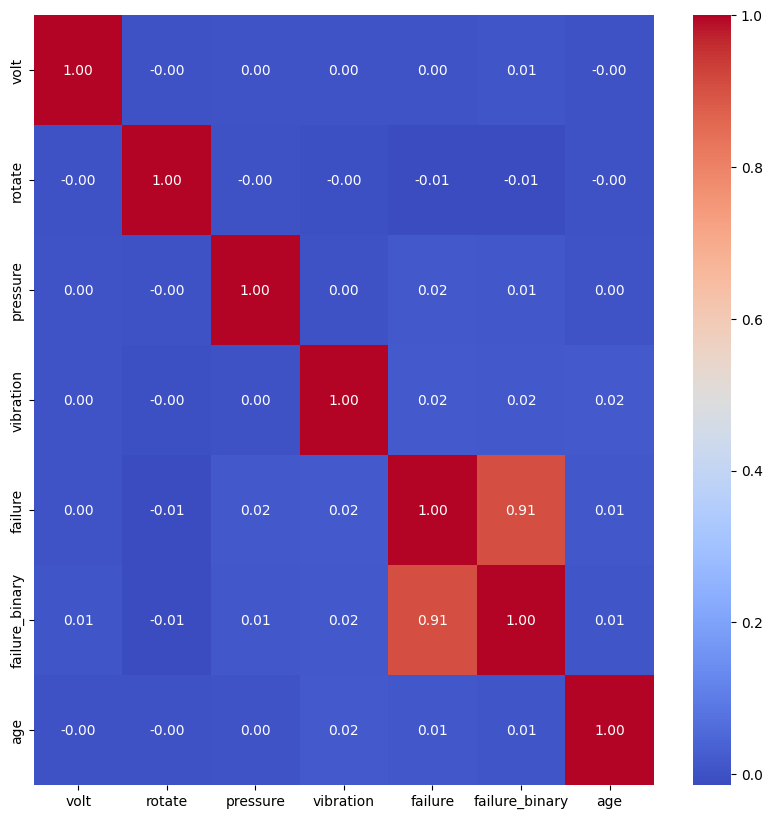

In [25]:
#df_failures_telemetry.drop(['datetime','machineID']).corr()
corr =  df_failures_telemetry.drop(['datetime','machineID'],1).corr()
# plot the heatmap, use seaborn
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')


In [26]:
df_failures_telemetry

# calcular la informacion mutua entre las variables 
from sklearn.feature_selection import mutual_info_classif


In [27]:
df_failures_telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration,failure,failure_binary,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0,0,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0,0,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0,0,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0,0,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0,0,model3,18


In [28]:
# calcular la informacion mutua entre las volt y la falla 
mutual_info_classif(df_failures_telemetry[['age']], df_failures_telemetry['failure_binary'], discrete_features=True)

array([3.61222118e-05])

In [ ]:
# make a line plot for each variable 
for col in df_failures_telemetry.drop(['datetime','machineID','failure_binary'],1).columns:
    df_failures_telemetry.plot(x='datetime', y=col, figsize=(15,5))
    plt.show()
    